#### Sanity checks using sparse structures. Everything here has been checked and works [except grouped sub-sampling]. 

* Note that there is an error with the stratification scheme itself as it sometimes does not work. 

* Since we always have an intercept term, we set the sampler for the first dimension to be the uniform minibatch sampler. 

In [1]:
using Distributions, TimeIt, PyPlot, NPZ
include("zz_structures.jl")
include("mbsampler.jl")

get_clustering (generic function with 1 method)

In [2]:
d, Nobs = 10, 1_000
X = sprandn(d, Nobs, 2e-2)
X[1,:] = ones(Nobs)
ξ_true = rand(Normal(),d)
y = [rand(Binomial(1, 1/(1+exp(-ξ_true'X[:,j]))), 1)[1] + 0. for j in 1:Nobs]

my_ll = ll_logistic_sp(X,y);
my_prior = gaussian_prior_nh(zeros(d),1*ones(d))
my_model = model(my_ll, my_prior);
root = find_root(my_model, rand(d));

In [3]:
mb_size = 50

50

In [14]:
# Sub-sampling with weights and no CV

weights_het = spzeros(d, Nobs)
for i in 1:d 
    nzind = X[i,:].nzind
    weights_het[i,nzind] = abs.(X[i,nzind])./sum(abs.(X[i,nzind]))
end

prob_het = 0.9
gs = Array{mbsampler}(d)
gs[1] = umbsampler(Nobs, mb_size)
for i in 2:d 
    gs[i] = spwumbsampler(Nobs, mb_size, weights_het[i,:], prob_het)
#     gs[i] = umbsampler(Nobs, mb_size)
end
gs_list = mbsampler_list(d,gs);

In [19]:
A = speye(d)
# A = spzeros(1,d)
# A[1,1] = 1
opf = projopf(A, 100) 
opt = maxa_opt(10^5)
outp = outputscheduler(opf,opt) ;

#### Run ZZ:

In [20]:
start = time()
@time ZZ_sample(my_model, outp, gs_list);
# print(size(outp.opf.xi_skeleton,2), " bounces accepted")

  6.013906 seconds (29.70 M allocations: 2.574 GiB, 5.25% gc time)


* Extract samples:

In [21]:
n_samples = 10^4
@timeit samples = extract_samples(outp.opf.xi_skeleton, 
                                  outp.opf.bt_skeleton, 
                                  outp.opf.bt_skeleton[end]/n_samples);

100 loops, best of 3: 1.52 ms per loop


#### Sanity check:

In [22]:
[compute_configT(my_model, samples, k) for k in 1:min(10,d)]

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


10-element Array{Float64,1}:
 0.00179805
 0.805131  
 1.12339   
 1.00838   
 0.697585  
 1.03454   
 1.10852   
 1.00636   
 1.2037    
 1.01019   

#### Plot ACFs:

In [52]:
maxlag = 200
acfs = zeros(d, maxlag)
for dim in 1:d 
    acfs[dim,:] = acf(samples[dim,:], maxlag)
end

acfs_toplot = []
xt = []
for i in 1:Int(maxlag/10) 
    push!(acfs_toplot, acfs[:,i*10])
    if i%5 == 0 
        push!(xt, 10*i)
    else 
        push!(xt, "")
    end
end

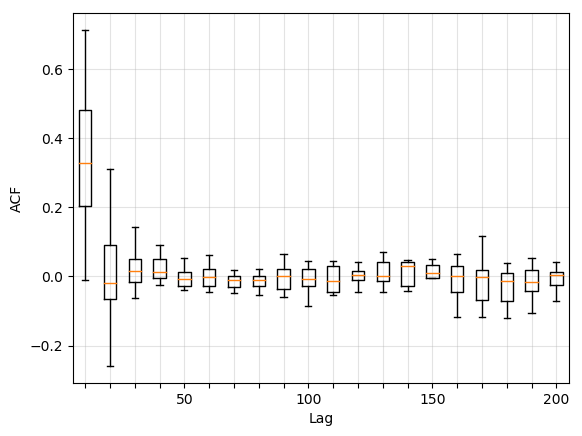

In [53]:
boxplot(acfs_toplot, showfliers=false)
grid(alpha=0.35)
xlabel("Lag", fontsize=10)
ylabel("ACF", fontsize=10)
xticks(1:Int(maxlag/10) , xt);

In [14]:
gc()